In [14]:
import torch
import torch.nn as nn
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from torchdiffeq import odeint, odeint_adjoint
from torch.func import vmap, jacrev, grad
from tqdm.notebook import tqdm

In [2]:
# device = "cuda:0"
device = "cpu"

In [3]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    return lambda x: torch.trace(J(x))

def output_and_div(vecfield, x):
    dx = vecfield(x)
    div = vmap(div_fn(vecfield))(x)
    return dx, div

def normal_logprob(z, mean, log_std):
    mean = mean + torch.tensor(0.)
    log_std = log_std + torch.tensor(0.)
    c = torch.tensor([math.log(2 * math.pi)]).to(z)
    inv_sigma = torch.exp(-log_std)
    tmp = (z - mean) * inv_sigma
    return -0.5 * (tmp * tmp + 2 * log_std + c)

In [28]:
class CNF(nn.Module):

    tol = 1e-5

    def  __init__(self, dim):
        super().__init__()
        self.dim = dim
        self._vecfield = nn.Sequential(
            nn.Linear(dim + 1, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, dim),
        )

    def vecfield(self, t, x):
        shape = x.shape
        x = x.reshape(-1, self.dim)
        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        tx = torch.cat([t, x], dim=-1)
        return self._vecfield(tx).reshape(shape)

    def logprob(self, x, t=1.0):
        if t == 0:
            return normal_logprob(x, 0.0, 0.0).sum(-1)

        def combined_CNF_system(t, state):
            x, _ = state
            dx, div = output_and_div(lambda x: self.vecfield(t, x), x)
            return dx, -div

        ldj = torch.zeros(x.shape[0]).to(x)
        x0, ldj = odeint(combined_CNF_system, (x, ldj), t=torch.linspace(t, 0, 2).to(x), method="dopri5", atol=self.tol, rtol=self.tol)
        x0, ldj = x0[-1], ldj[-1]
        logp0 = normal_logprob(x0, 0.0, 0.0).sum(-1)
        return logp0 - ldj
    
    def sample(self, x0, t=1.0):
        xt = odeint(self.vecfield, x0, t=torch.linspace(0, t, 2).to(x0), method="dopri5", atol=self.tol, rtol=self.tol)
        return xt[1]

    def sample_with_logprob(self, x0, t=1.0):
        def combined_CNF_system(t, state):
            x, _ = state
            dx, div = output_and_div(lambda x: self.vecfield(t, x), x)
            return dx, -div

        logprob = normal_logprob(x0, 0.0, 0.0).sum(-1)
        xt, logprob = odeint(combined_CNF_system, (x0, logprob), t=torch.linspace(0, t, 2).to(x0), method="dopri5", atol=self.tol, rtol=self.tol)
        xt, logprob = xt[-1], logprob[-1]
        return xt, logprob

    def sample_with_logprob_and_score(self, x0, t=1.0):
        def combined_CNF_system(t, state):
            x, _, score = state
            x = x.requires_grad_(True)
            dx, div = output_and_div(lambda x: self.vecfield(t, x), x)
            grad_div = torch.autograd.grad(div.sum(), x)[0]  # grad
            score_vjp = torch.autograd.grad(dx, x, grad_outputs=score)[0]  # vjp
            dlogp = -div
            dscore = -score_vjp - grad_div
            return dx, dlogp, dscore

        x0 = x0.requires_grad_(True)
        logprob = normal_logprob(x0, 0.0, 0.0).sum(-1)
        score = torch.autograd.grad(logprob.sum(), x0)[0]
        xt, logprob, scores = odeint(combined_CNF_system, (x0, logprob, score), t=torch.linspace(0, t, 2).to(x0), method="dopri5", atol=self.tol, rtol=self.tol)
        xt, logprob, score = xt[-1], logprob[-1], scores[-1]
        return xt, logprob, score

In [31]:
model = CNF(1).to(device)

torch.manual_seed(0)

x0 = torch.randn(10, 1)

# clever method
x, logprob, score = model.sample_with_logprob_and_score(x0)
print(score)

# ground truth
logp = model.logprob(x)
score = torch.autograd.grad(logp.sum(), x)[0]
print(score)

tensor([[-1.5653],
        [ 0.3090],
        [ 2.1067],
        [-0.5403],
        [ 1.0526],
        [ 1.3499],
        [-0.3714],
        [-0.8220],
        [ 0.7099],
        [ 0.4130]], grad_fn=<SelectBackward0>)
tensor([[-1.5654],
        [ 0.3089],
        [ 2.1067],
        [-0.5403],
        [ 1.0525],
        [ 1.3498],
        [-0.3714],
        [-0.8221],
        [ 0.7098],
        [ 0.4129]])


In [5]:
alphas = (1., 2.)
betas = (0.5, -1.0)

def T(model, batch_size, Ne):
    c = np.pi * np.pi * Ne**3 / 12
    x0 = torch.randn(batch_size, 1).to(device)
    _, logprob = model.sample_with_logprob(x0)
    rho = logprob.exp()
    return c * rho * rho

def H(model, batch_size, Ne):
    c = Ne**2 / 2
    x0 = torch.randn(batch_size * 2, 1).to(device)
    x = model.sample(x0)
    x, xp = x[:batch_size], x[batch_size:]
    return c / torch.abs(x - xp)

def V(model, batch_size, Ne):
    c = Ne
    x0 = torch.randn(batch_size, 1).to(device)
    x = model.sample(x0).reshape(-1)
    summa = 0.0
    for alpha, beta in zip(alphas, betas):
        summa = summa - alpha * torch.exp(-(x - beta)*(x - beta))
    return c * summa

In [6]:
def load_true_results(n_particles: int):
    import numpy as onp
    d_ = f'Data_1D_GaussMixPot/true_rho_grid_Ne_{n_particles}.txt'
    data = onp.loadtxt(d_)
    return data

In [7]:
def plot(model,ne):
    true_data = load_true_results(ne)
    xx = torch.linspace(-5, 5, 1000).to(device)
    logp = model.logprob(xx.reshape(-1, 1))

    p0 = normal_logprob(xx, 0.0, 0.0).exp()

    xx = xx.detach().cpu().numpy()
    logp = logp.detach().cpu().numpy()
    p0 = p0.detach().cpu().numpy()

    p_model = np.exp(logp)

    dx = (xx[1] - xx[0])
    approx_sum = np.sum(dx * p_model)
    print("integral estimate", approx_sum)

    potential = 0.0
    for alpha, beta in zip(alphas, betas):
        potential = potential - alpha * np.exp(-(xx - beta)*(xx - beta))

    plt.figure(figsize=(6, 3))
    plt.plot(xx, p0, color="k", alpha=0.5,label='init CNF')
    plt.plot(xx, p_model,label='CNF')
    plt.plot(xx, potential, linestyle="--")
    plt.plot(true_data[:,0],true_data[:,1],ls=":",color='k',label='SCF')
    plt.legend()

In [8]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

  0%|          | 0/101 [00:00<?, ?it/s]

iter 00000, loss -1.2838, T 0.0714, H 25.2984, V -1.3552, grad_norm 1.60
integral estimate 1.0000265
iter 00001, loss -1.4559, T 0.3481, H 4.7391, V -1.8040, grad_norm 2.36
integral estimate 0.9999851
iter 00002, loss -1.4490, T 0.1778, H 3.2696, V -1.6267, grad_norm 1.59
integral estimate 1.0000038
iter 00003, loss -1.4084, T 0.0815, H 1.4378, V -1.4900, grad_norm 1.93
integral estimate 1.0000325
iter 00004, loss -1.5433, T 0.2515, H 5.3704, V -1.7947, grad_norm 0.61
integral estimate 1.0000165
iter 00005, loss -1.4657, T 0.4423, H 4.5021, V -1.9080, grad_norm 2.57
integral estimate 0.9999857
iter 00006, loss -1.5517, T 0.2328, H 3.0143, V -1.7845, grad_norm 0.49
integral estimate 0.9999846


KeyboardInterrupt: 

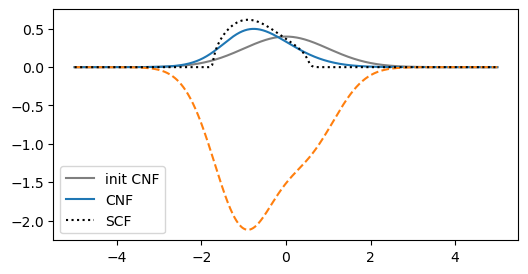

In [9]:
os.makedirs("figs", exist_ok=True)
os.makedirs("ckpts", exist_ok=True)

Ne = 1
batch_size=1024
grad_clip=1.0

model = CNF(1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

running_loss = RunningAverageMeter()
running_T = RunningAverageMeter()
running_H = RunningAverageMeter()
running_V = RunningAverageMeter()

for itr in tqdm(range(101)):
    optimizer.zero_grad()

    # H_coef = min(itr / 2000, 1.0)
    H_coef = 0.0
    
    T_val = T(model, batch_size, Ne)
    H_val = H(model, batch_size, Ne)
    V_val = V(model, batch_size, Ne)

    loss = T_val + H_coef * H_val + V_val
    loss = loss.mean()

    loss.backward()

    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()

    running_loss.update(loss.item())
    running_T.update(T_val.mean().item())
    running_H.update(H_val.mean().item())
    running_V.update(V_val.mean().item())
    
    print(f"iter {itr:05d}, loss {running_loss.val:.4f}, T {running_T.val:.4f}, H {running_H.val:.4f}, V {running_V.val:.4f}, grad_norm {grad_norm:.2f}")

    if itr % 10 == 0 or itr < 25:

        plot(model,Ne)
        plt.savefig(f"figs/{itr:06d}.png")
        plt.close()
    
    if itr % 500 == 0:
        torch.save(model.state_dict(), f"ckpts/ckpt-N={Ne}.pth")